In [29]:
##LIBRERIAS##
import numpy as np
import matplotlib.pyplot as plt

In [30]:
##PARÁMETROS INICIALES##
#VERIFICAR # 

R, Nr = 1.0, 40 #Radio del disco del bastón, nodos radiales
dr = R / Nr #pasos radiales 
r = np.linspace(dr, R, Nr)  # Empezar desde dr en lugar de 0 
DG, DE, DC = 0.5, 0.3, 5 # Coeficientes de  difusión de la transduccina, PDE activa y cGMP.
kG, kE, k2 = 2, 5.0, 5 #Coeficiente de desactivación de transduccina, de apagado de PDE activa y activación por cada transduccina.
alpha, beta, E_basal = 1.0, 1.0, 0.02 #Sintesis basal de cGMP y eficiencia de hidrólisis.

| Parámetro | Valor típico usado | Significado | Referencia |
|-----------|-------------------|-------------|------------|
| **D_G** (difusión de transducina activa) | 0.5–1.0 µm²/s | Movilidad lateral de G* en la membrana del disco | Menon et al. 2019 (*Biophys J*), Arshavsky 2002 |
| **D_E** (difusión de PDE activa) | 0.3–0.6 µm²/s | Movilidad lateral de PDE en la membrana | Pugh & Lamb 1993, Arshavsky 2002 |
| **D_C** (difusión de cGMP) | 5–10 µm²/s (usé 2–5 para estabilidad numérica) | Difusión de nucleótidos en el citoplasma del segmento externo | Koutalos & Yau 1996 (*Prog Retin Eye Res*) |
| **k_G** (apagado de G*) | 2–5 s⁻¹ | GTPasa en la subunidad α de transducina, acelerada por RGS9 | Krispel et al. 2006 (*Nature*), Burns & Pugh 2010 |
| **k_E** (apagado de PDE activa) | 3–6 s⁻¹ | Duración de PDE activa tras apagado de G* | Burns & Pugh 2010 (*Annu Rev Physiol*) |
| **k_2** (activación de PDE por G*) | 5–10 s⁻¹ | Eficiencia de activación de PDE por G-proteína activa | Leskov et al. 2000 (*Neuron*) |
| **α** (síntesis de cGMP) | Ajustado para equilibrio (≈1 arb. u.) | Producción por guanylate cyclase | Burns & Pugh 2010 |
| **β** (hidrólisis de cGMP por PDE) | Ajustado (≈1 arb. u.) | Consumo proporcional a E·C | Pugh & Lamb 1993 |
| **E_basal** (actividad basal de PDE) | 0.01–0.05 | Actividad de PDE en oscuridad (1–5% del máximo) | Burns & Pugh 2010 |
| **k_1** (tasa de activación de G* por R*) | 200–500 s⁻¹ | Una rodopsina activa puede activar cientos de G-proteínas por segundo | Pugh & Lamb 1993; Leskov et al. 2000 |
| **t_R** (vida de R*) | 50–200 ms (media ≈100 ms) | Duración de rodopsina activa antes de apagarse | Krispel et al. 2006; Burns & Pugh 2010 |


In [31]:
##DIFUSIÓN RADIAL MEMBRANAL ##

#  ∇^2 f = d ^2 f / d r^2 + 1/r * d f/ d r  
def laplaciano(f, dr, r):
    """
    Calcula el laplaciano radial con condiciones toroidales (periódicas).

    Parámetros
    ----------
    f : ndarray
        Perfil radial de la variable (G, E o C).
    dr : float
        Espaciado radial.
    r : ndarray
        Vector de coordenadas radiales.

    Retorna
    -------
    lap : ndarray
        Laplaciano radial con condiciones toroidales.
    """
    N = len(f)
    lap = np.zeros_like(f)

    # Índices periódicos: envolvemos los bordes
    f_ip1 = np.roll(f, -1)   # f_{i+1}, con f_N ≡ f_0
    f_im1 = np.roll(f, 1)    # f_{i-1}, con f_{-1} ≡ f_{N-1}

    # Operador laplaciano radial con simetría axial
    # Para r=0 (centro), usar fórmula especial
    for i in range(N):
        if r[i] == 0:
            # En el centro, usar aproximación para r=0
            # ∇²f ≈ 4 * (f_{i+1} - f_i) / dr²
            lap[i] = 4 * (f_ip1[i] - f[i]) / dr**2
        else:
            # Para r ≠ 0, usar fórmula normal
            lap[i] = (f_ip1[i] - 2 * f[i] + f_im1[i]) / dr**2 + \
                     (f_ip1[i] - f_im1[i]) / (2 * r[i] * dr)

    return lap


In [32]:
##ECUACIONES DIFERENCIALES ##

def rhs(t, G, E, C, laplaciano):
    dG = DG * laplaciano(G, dr, r) - kG * G 
    dG += fuente(t) + 2e2 * np.random.normal(0, 1, Nr) * np.sqrt(np.abs(G) + 1e-10)
    
    dE = DE * laplaciano(E, dr, r) + k2 * G - kE * E
    dC = DC * laplaciano(C, dr, r) + alpha - beta * (E_basal + E) * C
    
    return dG, dE, dC


#FUENTE de G
# fijamos la vida media de R* en ~0.1 s
mean_R = 0.1    # segundos
shape_R = 4.0   # forma de la Gamma
scale_R = mean_R / shape_R

# elegimos al azar una vida para este ensayo
t_R = np.random.gamma(shape=shape_R, scale=scale_R)

def fuente(t, Nr=40):
    profile = np.zeros(Nr)
    if t < t_R:           # mientras R* viva
        profile[0] = 300  # activa G* en el centro
    return profile

In [34]:
##SOLUCION DE ECUACIONES DIFERENCIALES##

# Tiempo
T = 10
dt_stable = (dr**2) / (8*max(DG, DE, DC))  # Más conservador
dt = min(5e-1, dt_stable)
Nt = int(np.ceil(T/dt))
times = np.arange(Nt) * dt


# ---------------- Estados iniciales ----------------
G = np.zeros(Nr)
E = np.full(Nr, E_basal)
C = np.full(Nr, alpha/(beta*E_basal))

G_mean, E_mean, C_mean = [], [], []

# ---------------- Integración temporal ----------------
for k in range(Nt):
    t = times[k]
    
    # Calcular las derivadas usando la función rhs
    dG, dE, dC = rhs(t, G, E, C, laplaciano)
    
    # Integrar usando el método de Euler
    G = G + dt * dG  
    E = E + dt * dE
    C = C + dt * dC
    
    # Asegurar que no haya valores negativos
    G = np.maximum(G, 0)
    E = np.maximum(E, 0)
    C = np.maximum(C, 0)
    
    # Guardar promedios
    G_mean.append(G.mean())
    E_mean.append(E.mean())
    C_mean.append(C.mean())

G_mean, E_mean, C_mean = np.array(G_mean), np.array(E_mean), np.array(C_mean)
C_norm = C_mean / C_mean[0]

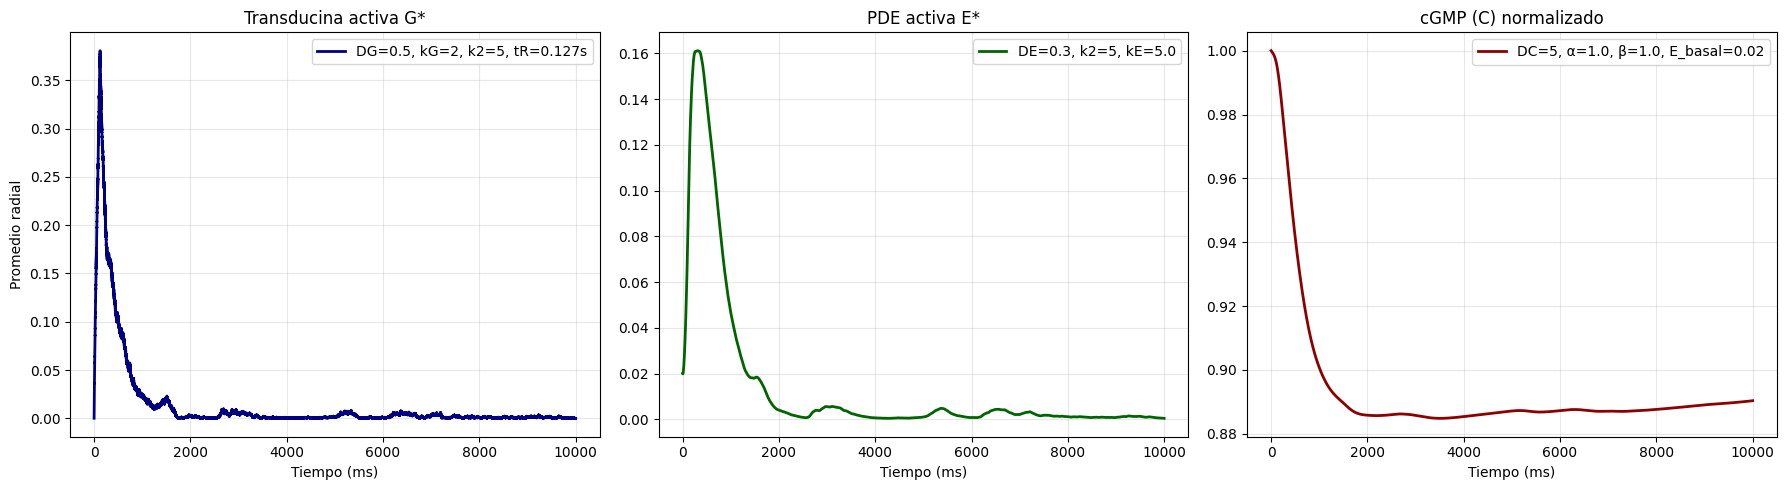

In [35]:
##PLOTEOS DE LAS ECUACIONES INICIALMENTE##

# ---------------- Gráfica (3 subplots en una fila) ----------------
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharex=True)

axes[0].plot(times*1000, G_mean, lw=2, color="navy",
             label=f"DG={DG}, kG={kG}, k2={k2}, tR={t_R:.3f}s")
axes[0].set_title("Transducina activa G*")
axes[0].set_xlabel("Tiempo (ms)")
axes[0].set_ylabel("Promedio radial")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(times*1000, E_mean, lw=2, color="darkgreen",
             label=f"DE={DE}, k2={k2}, kE={kE}")
axes[1].set_title("PDE activa E*")
axes[1].set_xlabel("Tiempo (ms)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(times*1000, C_norm, lw=2, color="darkred",
             label=f"DC={DC}, α={alpha}, β={beta}, E_basal={E_basal}")
axes[2].set_title("cGMP (C) normalizado")
axes[2].set_xlabel("Tiempo (ms)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
